In [1]:
import pyart
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [33]:
import cdsapi

dataset = "reanalysis-era5-pressure-levels"
request = {
    "product_type": ["reanalysis"],
    "variable": [
        "geopotential",
        "temperature",
        "u_component_of_wind",
        "v_component_of_wind",
        "vertical_velocity",
        "vorticity"
    ],
    "year": ["2021"],
    "month": ["05"],
    "day": ["16"],
    "time": ["03:00"],
    "pressure_level": ["850", "1000"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [18, 71, 13, 77]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-06-06 19:30:03,504 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-06-06 19:30:04,434 INFO Request ID is fdcdd2e6-853e-4a48-bbc9-b198ed2d66b1
2025-06-06 19:30:04,832 INFO status has been updated to accepted
2025-06-06 19:30:38,780 INFO status has been updated to running
2025-06-06 19:30:56,082 INFO status has been updated to successful


'c0ee09a9a6de0727d287e1af58197b9.nc'

In [2]:
def assign_latlon(ds):
    """Convert Cartesian coordinates to geographic coordinates"""
    rlon, rlat = pyart.core.cartesian_to_geographic_aeqd(
        ds.x.values,
        ds.y.values,
        np.nanmean(ds.origin_longitude.values),
        np.nanmean(ds.origin_latitude.values),
    )
    lon_2d, lat_2d = np.meshgrid(rlon, rlat)
    lon_coords = xr.DataArray(lon_2d, dims=("y", "x"))
    lat_coords = xr.DataArray(lat_2d, dims=("y", "x"))
    ds = ds.assign_coords({"lon": lon_coords, "lat": lat_coords})
    ds = ds.set_coords(["lat", "lon"])
    return ds

In [3]:
ds = xr.open_mfdataset(
    "/Users/syed44/Downloads/Others/Git_Stuff/imd_temp_radar/out/grid_GOA210516030244-IMD-B.nc")
ds = ds.pipe(assign_latlon)
ds = ds.sel(z=1500, method='nearest').squeeze()
print(ds)

<xarray.Dataset> Size: 9MB
Dimensions:                     (x: 500, y: 500)
Coordinates:
    time                        datetime64[ns] 8B 2021-05-16T03:03:06
  * x                           (x) float64 4kB -2.5e+05 -2.49e+05 ... 2.5e+05
  * y                           (y) float64 4kB -2.5e+05 -2.49e+05 ... 2.5e+05
    z                           float32 4B 1.625e+03
    lon                         (y, x) float64 2MB 71.51 71.52 ... 76.17 76.18
    lat                         (y, x) float64 2MB 13.22 13.22 ... 17.72 17.72
Data variables: (12/15)
    origin_latitude             float32 4B dask.array<chunksize=(), meta=np.ndarray>
    origin_longitude            float32 4B dask.array<chunksize=(), meta=np.ndarray>
    origin_altitude             float32 4B dask.array<chunksize=(), meta=np.ndarray>
    projection                  int32 4B ...
    ProjectionCoordinateSystem  int32 4B ...
    radar_latitude              float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ...           

In [4]:
era = xr.open_dataset('c0ee09a9a6de0727d287e1af58197b9.nc')
era = era.rename({'valid_time':'time',
                  'pressure_level':'pressure',
                  'latitude':'lat',
                  'longitude':'lon'
                 })

era = era.sel(pressure=850).squeeze()

era = era[['u', 'v']]

era = era.sel(lon=slice(ds.lon.min()-1, ds.lon.max()+1),
        lat=slice(ds.lat.max()+1, ds.lat.min()-1)
       )

print(era)

<xarray.Dataset> Size: 5kB
Dimensions:   (lat: 21, lon: 25)
Coordinates:
    number    int64 8B ...
    time      datetime64[ns] 8B 2021-05-16T03:00:00
    pressure  float64 8B 850.0
  * lat       (lat) float64 168B 18.0 17.75 17.5 17.25 ... 13.75 13.5 13.25 13.0
  * lon       (lon) float64 200B 71.0 71.25 71.5 71.75 ... 76.25 76.5 76.75 77.0
    expver    <U4 16B ...
Data variables:
    u         (lat, lon) float32 2kB ...
    v         (lat, lon) float32 2kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-06T14:00 GRIB to CDM+CF via cfgrib-0.9.1...


In [5]:
era

<xarray.Dataset> Size: 5kB
Dimensions:   (lat: 21, lon: 25)
Coordinates:
    number    int64 8B ...
    time      datetime64[ns] 8B 2021-05-16T03:00:00
    pressure  float64 8B 850.0
  * lat       (lat) float64 168B 18.0 17.75 17.5 17.25 ... 13.75 13.5 13.25 13.0
  * lon       (lon) float64 200B 71.0 71.25 71.5 71.75 ... 76.25 76.5 76.75 77.0
    expver    <U4 16B ...
Data variables:
    u         (lat, lon) float32 2kB ...
    v         (lat, lon) float32 2kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-06T14:00 GRIB to CDM+CF via cfgrib-0.9.1...

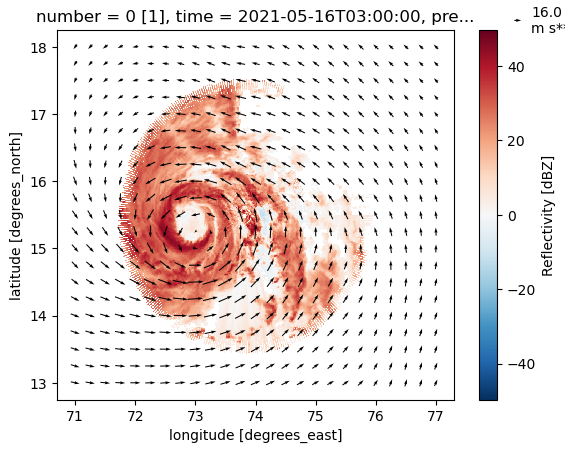

In [6]:
ds['Z'].plot(x='lon', y='lat')
era.plot.quiver(x='lon', y='lat', u='u', v='v')

In [7]:
import numpy as np
from scipy.interpolate import griddata
import xarray as xr

def interpolate_era5_to_radar(ds, era, method='linear'):
    """
    Interpolate ERA5 u, v onto radar grid (lat(y,x), lon(y,x)).

    Parameters
    ----------
    ds : xarray.Dataset
        Radar dataset with lat(y,x), lon(y,x)
    era : xarray.Dataset
        ERA5 dataset with u(lat,lon), v(lat,lon) already subset to radar domain
    method : str
        Interpolation method: 'linear' or 'nearest'

    Returns
    -------
    ds : xarray.Dataset
        Radar dataset with new variables u_era(y,x), v_era(y,x)
    """

    # Build 2D ERA5 grid
    era_lon2d, era_lat2d = np.meshgrid(era['lon'].values, era['lat'].values)

    # Flatten ERA5 grid
    points_era = np.stack([era_lat2d.ravel(), era_lon2d.ravel()], axis=-1)

    # Flatten ERA5 u and v
    u_values = era['u'].values.ravel()
    v_values = era['v'].values.ravel()

    # Radar grid
    lat_radar = ds['lat'].values
    lon_radar = ds['lon'].values

    # Flatten radar grid for interpolation
    points_radar = np.stack([lat_radar.ravel(), lon_radar.ravel()], axis=-1)

    # Interpolate u, v
    u_on_radar = griddata(points_era, u_values, points_radar, method=method)
    v_on_radar = griddata(points_era, v_values, points_radar, method=method)

    # Reshape to radar grid shape
    u_on_radar = u_on_radar.reshape(lat_radar.shape)
    v_on_radar = v_on_radar.reshape(lat_radar.shape)

    # Convert to xarray DataArrays
    u_da = xr.DataArray(
        u_on_radar,
        coords={'y': ds['y'], 'x': ds['x']},
        dims=('y', 'x'),
        name='u_era'
    )

    v_da = xr.DataArray(
        v_on_radar,
        coords={'y': ds['y'], 'x': ds['x']},
        dims=('y', 'x'),
        name='v_era'
    )

    # Assign to ds and return
    ds = ds.assign(u_era=u_da, v_era=v_da)
    return ds

In [8]:
ds = interpolate_era5_to_radar(ds, era, method='linear')

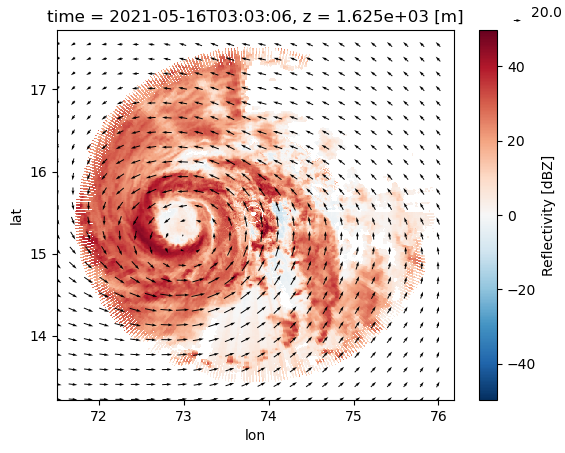

In [9]:
ds['Z'].plot(x='lon', y='lat',)
ds.sel(x=slice(None, None, 20),
       y=slice(None, None, 20)).plot.quiver(x='lon', y='lat', u='u_era', v='v_era')